In [131]:
import torch, pandas as pd, matplotlib.pyplot as plt, numpy as np, random, timeit
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score
from tqdm import tqdm

In [57]:
# Constantes para configuração do modelo e do treinamento

# Semente aleatória para reprodutibilidade
RANDON_SEED = 42

# Tamanho do lote (batch) para o treinamento
BATCH_SIZE = 512

# Número de épocas de treinamento
EPOCHS = 73

# Taxa de aprendizagem (learning rate) para o otimizador
LEARNING_RATE = 1e-4

# Número de classes no conjunto de dados (no caso do MNIST, 10 dígitos)
NUM_CLASSES = 10

# Tamanho do patch para a extração de características das imagens
PATCH_SIZE = 4

# Tamanho da imagem (28x28 para o MNIST)
IMG_SIZE = 28

# Número de canais de entrada (1 para imagens em escala de cinza)
IN_CHANNELS = 1

# Número de cabeças de atenção no mecanismo de atenção multi-cabeça
NUM_HEADS = 8

# Taxa de dropout para regularização
DROPOUT = 1e-3

# Dimensão oculta para camadas lineares no codificador
HIDDEN_DIM = 768

# Peso de decaimento para o otimizador Adam
ADAM_WEIGHT_DECAY = 0

# Betas para o otimizador Adam
ADAM_BETAS = (0.9, 0.999)

# Função de ativação para o codificador
ACTIVATION_FN = "gelu"

# Número de camadas de codificador na arquitetura Transformer
NUM_ENCODERS = 4

# Dimensão de embedding (calculada com base no tamanho do patch e nos canais de entrada)
EMBED_DIM = (PATCH_SIZE**2) * IN_CHANNELS  # (4^2) * 1 = 16

# Número total de patches em uma imagem (calculado com base no tamanho da imagem e do patch)
NUM_PATCHS = (IMG_SIZE // PATCH_SIZE) ** 2  # 49

# Configuração da semente aleatória para garantir reprodutibilidade
random.seed(RANDON_SEED)
np.random.seed(RANDON_SEED)
torch.manual_seed(RANDON_SEED)
torch.cuda.manual_seed(RANDON_SEED)
torch.cuda.manual_seed_all(RANDON_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Dispositivo de execução (GPU se disponível, caso contrário, CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [56]:
torch.cuda.is_available()

True

In [34]:
# Classe para Embutir os Patches das Imagens


class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()

        # Definindo a estrutura para extrair os patches
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2),
        )

        # Token de classificação
        self.cls_token = nn.Parameter(
            torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True
        )

        # Embeddings de posição
        self.position_embeddings = nn.Parameter(
            torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True
        )

        # Dropout
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Expandindo o token de classificação para o batch
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        # Passe adiante para extrair os patches e rearranjá-los
        x = self.patcher(x).permute(0, 2, 1)

        # Concatenando o token de classificação com os patches
        x = torch.cat([cls_token, x], dim=1)

        # Adicionando os embeddings de posição
        x = self.position_embeddings + x

        # Aplicando dropout
        x = self.dropout(x)

        return x

In [37]:
# Testando codagem feita
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHS, DROPOUT, IN_CHANNELS).to("cuda")
x = torch.randn(512, 1, 28, 28)


In [38]:
# Classe para Vision Transformer (ViT)
class ViT(nn.Module):
    def __init__(
        self,
        num_patches,
        img_size,
        num_classes,
        patch_size,
        embed_dim,
        num_encoders,
        num_heads,
        hidden_dim,
        dropout,
        activation,
        in_channels,
    ):
        super().__init__()

        # Bloco de embeddings
        self.embeddings_block = PatchEmbedding(
            embed_dim, patch_size, num_patches, dropout, in_channels
        )

        # Camadas de codificador
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True,
        )

        # Bloco de codificador
        self.encoder_blocks = nn.TransformerEncoder(
            encoder_layer, num_layers=num_encoders
        )

        # Cabeça MLP
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes),
        )

    def forward(self, x):
        # Passar pelas camadas de embedding
        x = self.embeddings_block(x)

        # Passar pelos blocos de codificador
        x = self.encoder_blocks(x)

        # Aplicar a cabeça MLP apenas no token CLS
        x = self.mlp_head(x[:, 0, :])

        return x

In [40]:
model = ViT(
    NUM_PATCHS, 
    IMG_SIZE, 
    NUM_CLASSES, 
    PATCH_SIZE, 
    EMBED_DIM,
    NUM_ENCODERS,
    NUM_HEADS,
    HIDDEN_DIM,
    DROPOUT,
    ACTIVATION_FN,
    IN_CHANNELS
    ).to("cuda")
x = torch.rand(512, 1, 28, 28)
# print(model(x).shape)

In [117]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [44]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
train_df, pred_def = train_test_split(train_df, test_size=.25, random_state=RANDON_SEED, shuffle=True)

train_df, val_df = train_test_split(train_df, test_size=.1, random_state=RANDON_SEED, shuffle=True)

In [47]:
# Conjunto de Dados de Treinamento para MNIST
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indices) -> None:
        super().__init__()

        # Inicialização dos dados
        self.images = images
        self.labels = labels
        self.indices = indices

        # Transformações das imagens
        self.transform = transforms.Compose(
            [
                transforms.ToPILImage(),  # Converter para imagem PIL
                transforms.RandomRotation(15),  # Rotação aleatória de até 15 graus
                transforms.ToTensor(),  # Converter para tensor
                transforms.Normalize([0.5], [0.5]),  # Normalizar os pixels
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index) -> any:
        # Obter a imagem, rótulo e índice para o índice fornecido
        image = (
            self.images[index].reshape((28, 28)).astype(np.uint8)
        )  # Reshape e converter para uint8
        label = self.labels[index]  # Obter o rótulo
        index = self.indices[index]  # Obter o índice
        image = self.transform(image)  # Aplicar transformações à imagem

        # Retornar um dicionário contendo a imagem, rótulo e índice
        return {
            "image": image,  # Imagem transformada
            "label": label,  # Rótulo
            "index": index,  # Índice
        }

In [48]:
# Conjunto de Dados de Validação para MNIST
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indices) -> None:
        super().__init__()

        # Inicialização dos dados
        self.images = images
        self.labels = labels
        self.indices = indices

        # Transformações das imagens
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),  # Converter para tensor
                transforms.Normalize([0.5], [0.5]),  # Normalizar os pixels
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index) -> any:
        # Obter a imagem, rótulo e índice para o índice fornecido
        image = (
            self.images[index].reshape((28, 28)).astype(np.uint8)
        )  # Reshape e converter para uint8
        label = self.labels[index]  # Obter o rótulo
        index = self.indices[index]  # Obter o índice
        image = self.transform(image)  # Aplicar transformações à imagem

        # Retornar um dicionário contendo a imagem, rótulo e índice
        return {"image": image, "label": label, "index": index}

In [49]:
# Conjunto de Dados de Submissão para MNIST
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indices) -> None:
        super().__init__()

        # Inicialização dos dados
        self.images = images
        self.indices = indices

        # Transformações das imagens
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),  # Converter para tensor
                transforms.Normalize([0.5], [0.5]),  # Normalizar os pixels
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index) -> any:
        # Obter a imagem e o índice para o índice fornecido
        image = (
            self.images[index].reshape((28, 28)).astype(np.uint8)
        )  # Reshape e converter para uint8
        index = self.indices[index]  # Obter o índice
        image = self.transform(image)  # Aplicar transformações à imagem

        # Retornar um dicionário contendo a imagem e o índice
        return {"image": image, "index": index}

In [119]:
# Criando os conjuntos de dados de treinamento, validação e teste para MNIST

# Conjunto de dados de treinamento
train_dataset = MNISTTrainDataset(
    train_df.iloc[:, 1:].values.astype(
        np.uint8
    ),  # Imagens de treinamento convertidas para uint8
    train_df.iloc[:, 0].values,  # Rótulos de treinamento
    train_df.index.values,  # Índices dos dados de treinamento
)

# Conjunto de dados de validação
val_dataset = MNISTValDataset(
    val_df.iloc[:, 1:].values.astype(
        np.uint8
    ),  # Imagens de validação convertidas para uint8
    val_df.iloc[:, 0].values,  # Rótulos de validação
    val_df.index.values,  # Índices dos dados de validação
)

# Conjunto de dados de teste/submissão
test_dataset = MNISTSubmitDataset(
    test_df.values.astype(
        np.uint8
    ),  # Imagens de teste/submissão convertidas para uint8
    test_df.index.values,  # Índices dos dados de teste/submissão
)

# pred_def
pred_dataset = MNISTValDataset(
    pred_def.iloc[:, 1:].values.astype(
        np.uint8
    ),  # Imagens de validação convertidas para uint8
    pred_def.iloc[:, 0].values,  # Rótulos de validação
    pred_def.index.values,  # Índices dos dados de validação
)

<Figure size 640x480 with 0 Axes>

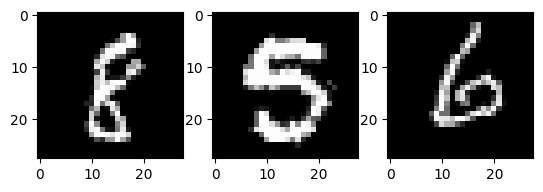

In [51]:
plt.figure()
f, axarr = plt.subplots(1, 3)
for i in range(3):
    axarr[i].imshow(train_dataset[i]["image"].squeeze(), cmap="gray")

In [120]:
# Criando os dataloaders para os conjuntos de dados de treinamento, validação e teste

# Dataloader para o conjunto de dados de treinamento
train_dataloader = DataLoader(
    dataset=train_dataset,  # Conjunto de dados de treinamento
    batch_size=BATCH_SIZE,  # Tamanho do lote (batch)
    shuffle=True,  # Embaralhar os dados durante o treinamento
)

# Dataloader para o conjunto de dados de validação
val_dataloader = DataLoader(
    dataset=val_dataset,  # Conjunto de dados de validação
    batch_size=BATCH_SIZE,  # Tamanho do lote (batch)
    shuffle=True,  # Embaralhar os dados durante a validação (pode não ser necessário, dependendo do contexto)
)

# Dataloader para o conjunto de dados de teste/submissão
test_dataloader = DataLoader(
    dataset=test_dataset,  # Conjunto de dados de teste/submissão
    batch_size=BATCH_SIZE,  # Tamanho do lote (batch)
    shuffle=False,  # Não há necessidade de embaralhar os dados durante o teste/submissão
)

pred_dataloader = DataLoader(
    dataset=pred_dataset,  # Conjunto de dados de teste/submissão
    batch_size=BATCH_SIZE,  # Tamanho do lote (batch)
    shuffle=False,  # Não há necessidade de embaralhar os dados durante o teste/submissão
)


In [53]:
# Definição da função de perda (loss) e do otimizador para o modelo

# Função de perda (loss)
criterion = nn.CrossEntropyLoss()

# Otimizador Adam
optimizer = optim.Adam(
    model.parameters(),  # Parâmetros do modelo a serem otimizados
    betas=ADAM_BETAS,  # Fatores de decaimento de momento (Adam betas)
    lr=LEARNING_RATE,  # Taxa de aprendizagem (learning rate)
    weight_decay=ADAM_WEIGHT_DECAY,  # Penalização de L2 (weight decay) para regularização
)

In [86]:
sample_submission = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")

In [ ]:
# Treinamento do modelo com laço de épocas

# Inicialização do tempo de execução
start = timeit.default_timer()

# Laço de épocas
for epoch in tqdm(range(train_df.shape[0] // BATCH_SIZE), position=0, leave=True):
    # Modo de treinamento
    model.train()
    train_labels, train_preds, train_running_loss = [], [], 0

    # Laço de treinamento
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = (
            img_label["image"].float().to("cuda")
        )  # Obter as imagens e enviá-las para o dispositivo
        label = (
            img_label["label"].type(torch.uint8).to("cuda")
        )  # Obter os rótulos e enviá-los para o dispositivo

        y_pred = model(img)  # Fazer a previsão
        y_pred_label = torch.argmax(y_pred, dim=1)  # Obter as previsões

        train_labels.extend(label.cpu().detach())  # Adicionar os rótulos verdadeiros
        train_preds.extend(y_pred_label.cpu().detach())  # Adicionar as previsões

        loss = criterion(y_pred, label)  # Calcular a perda

        optimizer.zero_grad()  # Zerar os gradientes
        loss.backward()  # Retropropagação
        optimizer.step()  # Atualizar os pesos

        train_running_loss += loss.item()  # Somar a perda

    train_loss = train_running_loss / (idx + 1)  # Calcular a média da perda

    # Modo de avaliação
    model.eval()
    val_labels, val_preds, val_running_loss = [], [], 0

    # Avaliação no conjunto de validação
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = (
                img_label["image"].float().to("cuda")
            )  # Obter as imagens e enviá-las para o dispositivo
            label = (
                img_label["label"].type(torch.uint8).to("cuda")
            )  # Obter os rótulos e enviá-los para o dispositivo}

            y_pred = model(img)  # Fazer a previsão
            y_pred_label = torch.argmax(y_pred, dim=1)  # Obter as previsões

            val_labels.extend(label.cpu().detach())  # Adicionar os rótulos verdadeiros
            val_preds.extend(y_pred_label.cpu().detach())  # Adicionar as previsões

            loss = criterion(y_pred, label)  # Calcular a perda
            val_running_loss += loss.item()  # Somar a perda

    val_loss = val_running_loss / (idx + 1)  # Calcular a média da perda

    # Imprimir as métricas de treinamento e validação
    print("-" * 30)
    print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(
        f"Train accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}"
    )
    print(
        f"Validation accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}"
    )

# Fim do tempo de execução
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")  # Imprimir o tempo total de treinamento

100%|██████████| 7/7 [00:00<00:00, 10.55it/s]


------------------------------
Train Loss EPOCH 1: 0.1752
Validation Loss EPOCH 1: 0.1406


  2%|▏         | 1/55 [00:16<15:03, 16.73s/it]

Train accuracy EPOCH 1: 0.9470
Validation accuracy EPOCH 1: 0.9578


100%|██████████| 7/7 [00:00<00:00, 11.79it/s]


------------------------------
Train Loss EPOCH 2: 0.1756
Validation Loss EPOCH 2: 0.1405
Train accuracy EPOCH 2: 0.9442


  4%|▎         | 2/55 [00:33<14:44, 16.69s/it]

Validation accuracy EPOCH 2: 0.9610


100%|██████████| 7/7 [00:00<00:00, 11.70it/s]


------------------------------
Train Loss EPOCH 3: 0.1734
Validation Loss EPOCH 3: 0.1462
Train accuracy EPOCH 3: 0.9468


  5%|▌         | 3/55 [00:50<14:29, 16.73s/it]

Validation accuracy EPOCH 3: 0.9546


100%|██████████| 7/7 [00:00<00:00, 11.31it/s]


------------------------------
Train Loss EPOCH 4: 0.1737
Validation Loss EPOCH 4: 0.1203


  7%|▋         | 4/55 [01:07<14:17, 16.80s/it]

Train accuracy EPOCH 4: 0.9474
Validation accuracy EPOCH 4: 0.9644


100%|██████████| 7/7 [00:00<00:00, 11.89it/s]


------------------------------
Train Loss EPOCH 5: 0.1726
Validation Loss EPOCH 5: 0.1332


  9%|▉         | 5/55 [01:24<14:07, 16.95s/it]

Train accuracy EPOCH 5: 0.9472
Validation accuracy EPOCH 5: 0.9594


100%|██████████| 7/7 [00:00<00:00, 12.06it/s]


------------------------------
Train Loss EPOCH 6: 0.1710
Validation Loss EPOCH 6: 0.1416


 11%|█         | 6/55 [01:40<13:44, 16.83s/it]

Train accuracy EPOCH 6: 0.9468
Validation accuracy EPOCH 6: 0.9644


100%|██████████| 7/7 [00:00<00:00, 12.06it/s]


------------------------------
Train Loss EPOCH 7: 0.1652
Validation Loss EPOCH 7: 0.1731
Train accuracy EPOCH 7: 0.9490


 13%|█▎        | 7/55 [01:57<13:26, 16.79s/it]

Validation accuracy EPOCH 7: 0.9483


100%|██████████| 7/7 [00:00<00:00, 10.71it/s]


------------------------------
Train Loss EPOCH 8: 0.1759
Validation Loss EPOCH 8: 0.1288
Train accuracy EPOCH 8: 0.9460


 15%|█▍        | 8/55 [02:14<13:08, 16.78s/it]

Validation accuracy EPOCH 8: 0.9594


100%|██████████| 7/7 [00:01<00:00,  6.57it/s]


------------------------------
Train Loss EPOCH 9: 0.1757
Validation Loss EPOCH 9: 0.1356
Train accuracy EPOCH 9: 0.9463


 16%|█▋        | 9/55 [02:31<12:59, 16.94s/it]

Validation accuracy EPOCH 9: 0.9629


100%|██████████| 7/7 [00:00<00:00, 11.68it/s]


------------------------------
Train Loss EPOCH 10: 0.1647
Validation Loss EPOCH 10: 0.1559
Train accuracy EPOCH 10: 0.9486


 18%|█▊        | 10/55 [02:48<12:37, 16.83s/it]

Validation accuracy EPOCH 10: 0.9606


100%|██████████| 7/7 [00:00<00:00, 11.90it/s]


------------------------------
Train Loss EPOCH 11: 0.1637
Validation Loss EPOCH 11: 0.1303


 20%|██        | 11/55 [03:04<12:13, 16.67s/it]

Train accuracy EPOCH 11: 0.9501
Validation accuracy EPOCH 11: 0.9613


100%|██████████| 7/7 [00:00<00:00, 11.79it/s]


------------------------------
Train Loss EPOCH 12: 0.1607
Validation Loss EPOCH 12: 0.1309
Train accuracy EPOCH 12: 0.9502


 22%|██▏       | 12/55 [03:20<11:47, 16.46s/it]

Validation accuracy EPOCH 12: 0.9638


100%|██████████| 7/7 [00:00<00:00, 10.84it/s]


------------------------------
Train Loss EPOCH 13: 0.1551
Validation Loss EPOCH 13: 0.1299


 24%|██▎       | 13/55 [03:36<11:30, 16.44s/it]

Train accuracy EPOCH 13: 0.9532
Validation accuracy EPOCH 13: 0.9616


100%|██████████| 7/7 [00:00<00:00, 12.23it/s]


------------------------------
Train Loss EPOCH 14: 0.1569
Validation Loss EPOCH 14: 0.1305
Train accuracy EPOCH 14: 0.9510


 25%|██▌       | 14/55 [03:53<11:13, 16.44s/it]

Validation accuracy EPOCH 14: 0.9632


100%|██████████| 7/7 [00:00<00:00, 10.50it/s]


------------------------------
Train Loss EPOCH 15: 0.1587
Validation Loss EPOCH 15: 0.1267


 27%|██▋       | 15/55 [04:09<10:54, 16.35s/it]

Train accuracy EPOCH 15: 0.9506
Validation accuracy EPOCH 15: 0.9619


100%|██████████| 7/7 [00:00<00:00, 11.84it/s]


------------------------------
Train Loss EPOCH 16: 0.1607
Validation Loss EPOCH 16: 0.1265


 29%|██▉       | 16/55 [04:25<10:37, 16.35s/it]

Train accuracy EPOCH 16: 0.9503
Validation accuracy EPOCH 16: 0.9616


100%|██████████| 7/7 [00:00<00:00, 11.69it/s]


------------------------------
Train Loss EPOCH 17: 0.1558
Validation Loss EPOCH 17: 0.1224
Train accuracy EPOCH 17: 0.9521


 31%|███       | 17/55 [04:41<10:18, 16.28s/it]

Validation accuracy EPOCH 17: 0.9616


100%|██████████| 7/7 [00:00<00:00, 10.53it/s]


------------------------------
Train Loss EPOCH 18: 0.1481
Validation Loss EPOCH 18: 0.1215
Train accuracy EPOCH 18: 0.9552


 33%|███▎      | 18/55 [04:58<10:07, 16.43s/it]

Validation accuracy EPOCH 18: 0.9648


100%|██████████| 7/7 [00:00<00:00, 11.53it/s]


------------------------------
Train Loss EPOCH 19: 0.1563
Validation Loss EPOCH 19: 0.1285
Train accuracy EPOCH 19: 0.9519


 35%|███▍      | 19/55 [05:14<09:47, 16.31s/it]

Validation accuracy EPOCH 19: 0.9606


100%|██████████| 7/7 [00:00<00:00, 11.65it/s]


------------------------------
Train Loss EPOCH 20: 0.1579
Validation Loss EPOCH 20: 0.1340
Train accuracy EPOCH 20: 0.9504


 36%|███▋      | 20/55 [05:30<09:29, 16.28s/it]

Validation accuracy EPOCH 20: 0.9641


100%|██████████| 7/7 [00:00<00:00, 11.61it/s]


------------------------------
Train Loss EPOCH 21: 0.1535
Validation Loss EPOCH 21: 0.1244
Train accuracy EPOCH 21: 0.9528


 38%|███▊      | 21/55 [05:47<09:12, 16.26s/it]

Validation accuracy EPOCH 21: 0.9613


100%|██████████| 7/7 [00:00<00:00, 12.01it/s]


------------------------------
Train Loss EPOCH 22: 0.1485
Validation Loss EPOCH 22: 0.1551
Train accuracy EPOCH 22: 0.9544


 40%|████      | 22/55 [06:03<08:55, 16.23s/it]

Validation accuracy EPOCH 22: 0.9587


100%|██████████| 7/7 [00:00<00:00, 11.46it/s]


------------------------------
Train Loss EPOCH 23: 0.1526
Validation Loss EPOCH 23: 0.1403
Train accuracy EPOCH 23: 0.9533


 42%|████▏     | 23/55 [06:20<08:44, 16.38s/it]

Validation accuracy EPOCH 23: 0.9584


100%|██████████| 7/7 [00:00<00:00, 12.04it/s]


------------------------------
Train Loss EPOCH 24: 0.1530
Validation Loss EPOCH 24: 0.1141
Train accuracy EPOCH 24: 0.9530


 44%|████▎     | 24/55 [06:36<08:25, 16.29s/it]

Validation accuracy EPOCH 24: 0.9635


100%|██████████| 7/7 [00:00<00:00, 12.15it/s]


------------------------------
Train Loss EPOCH 25: 0.1517
Validation Loss EPOCH 25: 0.1264
Train accuracy EPOCH 25: 0.9539


 45%|████▌     | 25/55 [06:52<08:09, 16.31s/it]

Validation accuracy EPOCH 25: 0.9648


100%|██████████| 7/7 [00:00<00:00, 12.17it/s]


------------------------------
Train Loss EPOCH 26: 0.1455
Validation Loss EPOCH 26: 0.1192
Train accuracy EPOCH 26: 0.9541


 47%|████▋     | 26/55 [07:08<07:51, 16.26s/it]

Validation accuracy EPOCH 26: 0.9629


100%|██████████| 7/7 [00:00<00:00, 11.08it/s]


------------------------------
Train Loss EPOCH 27: 0.1449
Validation Loss EPOCH 27: 0.1146
Train accuracy EPOCH 27: 0.9549


 49%|████▉     | 27/55 [07:25<07:37, 16.32s/it]

Validation accuracy EPOCH 27: 0.9654


100%|██████████| 7/7 [00:00<00:00, 11.83it/s]


------------------------------
Train Loss EPOCH 28: 0.1463
Validation Loss EPOCH 28: 0.1310
Train accuracy EPOCH 28: 0.9542


 51%|█████     | 28/55 [07:41<07:20, 16.32s/it]

Validation accuracy EPOCH 28: 0.9629


100%|██████████| 7/7 [00:00<00:00, 12.32it/s]


------------------------------
Train Loss EPOCH 29: 0.1482
Validation Loss EPOCH 29: 0.1283
Train accuracy EPOCH 29: 0.9534


 53%|█████▎    | 29/55 [07:57<07:02, 16.26s/it]

Validation accuracy EPOCH 29: 0.9616


100%|██████████| 7/7 [00:00<00:00, 11.72it/s]


------------------------------
Train Loss EPOCH 30: 0.1479
Validation Loss EPOCH 30: 0.1217


 55%|█████▍    | 30/55 [08:13<06:46, 16.27s/it]

Train accuracy EPOCH 30: 0.9543
Validation accuracy EPOCH 30: 0.9603


100%|██████████| 7/7 [00:00<00:00, 11.96it/s]


------------------------------
Train Loss EPOCH 31: 0.1440
Validation Loss EPOCH 31: 0.1218
Train accuracy EPOCH 31: 0.9546


 56%|█████▋    | 31/55 [08:30<06:29, 16.23s/it]

Validation accuracy EPOCH 31: 0.9610


 77%|███████▋  | 43/56 [00:12<00:03,  3.57it/s]

In [101]:
sample_submission = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
sample_submission

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [125]:
labels_true = pred_def["label"].values

In [126]:
# Previsão do modelo nos dados de teste/submissão

# Listas para armazenar rótulos, IDs e imagens
labels, ids, imgs = [], [], []

# Modo de avaliação
model.eval()

# Avaliação sem cálculo de gradientes
with torch.no_grad():
    # Iteração sobre os dados de teste/submissão
    for idx, sample in enumerate(tqdm(pred_dataloader, position=0, leave=True)):
        img = sample["image"].to(
            device
        )  # Obtenção das imagens e envio para o dispositivo
        
        id_ = [int(i) + 1 for i in sample["index"]]
        ids.extend(
            id_
        )  # Adicionar IDs aos quais 1 é somado para compatibilidade com a indexação do Kaggle

        outputs = model(img)  # Obtenção das previsões
        
        imgs.extend(img.detach().cpu())  # Adicionar as imagens
        label_ = [int(i) for i in torch.argmax(outputs, dim=1)]
        labels.extend(
            label_
        )  # Adicionar os rótulos previstos
        
        

100%|██████████| 21/21 [00:02<00:00,  9.23it/s]


<Figure size 640x480 with 0 Axes>

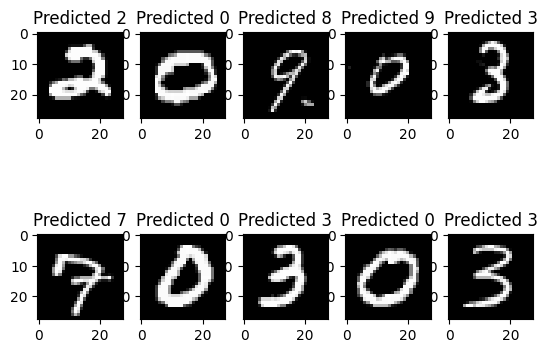

In [109]:
# Plotagem das imagens com rótulos previstos

# Criação da figura e dos eixos
plt.figure()
f, axarr = plt.subplots(2, 5)

# Contador para iterar sobre as imagens
counter = 0

# Iteração para plotar as imagens e rótulos previstos
for i in range(2):
    for j in range(5):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")  # Plotagem da imagem
        axarr[i][j].set_title(
            f"Predicted {labels[counter]}"
        )  # Definição do título com o rótulo previsto
        counter += 1  # Atualização do contador para a próxima imagem

In [141]:
taxa_acerto = accuracy_score(labels_true, labels)
matriz = confusion_matrix(labels_true, labels)
f1_ = f1_score(labels_true, labels, average='micro')

In [143]:
print(f"Taxa de Acerto: {(taxa_acerto * 100):.2f}%")
print(f"F1 Score: {(f1_ * 100):.2f}")

Taxa de Acerto: 96.66%
F1 Score: 96.66


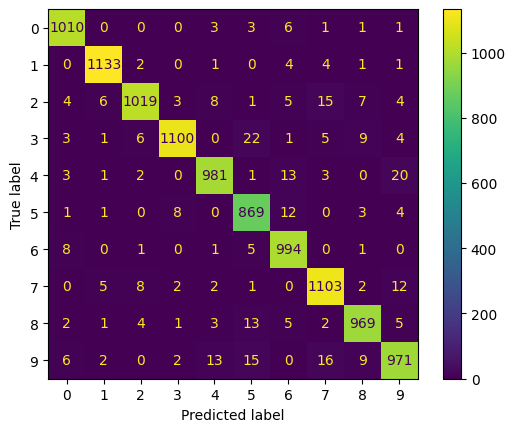

In [134]:
disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
disp.plot()